# 210323 Find species overlaps

In [1]:
using JSON
using Mmap
using CSV
using LinearAlgebra

In [2]:
using ProgressMeter
using DataFrames
using FilePathsBase
using FilePathsBase: /
using DataStructures
using PlotlyJS

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-3058962504575306873\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-14565860710324223585\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-3058962504575306873\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [3]:
using Midas
using Midas.Pairwise: npairs, iterpairs
using Midas.Overlaps
using TriMatrices

## Setup

In [4]:
ENV["COLUMNS"] = 400

400

In [5]:
DATESTR = "210323"
NBNAME = "$DATESTR-find-species-overlaps"

"210323-find-species-overlaps"

In [6]:
infiles = Dict(
    :distances => p"../../data/intermediate/200727-find-overlaps/genome-pw-distances.raw-float32",
    :formatted => p"data-intermediate/210303-format-data/",
);

In [7]:
intermediate_out = p"data-intermediate" / NBNAME
isdir(intermediate_out) || mkdir(intermediate_out)

p"data-intermediate/210323-find-species-overlaps"

## Load data

### Genomes

In [8]:
genomes_df = DataFrame(CSV.File(infiles[:formatted] / "genomes-v1.1.csv"))

ngenomes = nrow(genomes_df)

50752

### Species

In [9]:
species_df = DataFrame(CSV.File(infiles[:formatted] / "species-v1.2.csv"))

nspecies = nrow(species_df)

1438

In [10]:
gidxs_by_species = [Int[] for i in 1:nspecies]

for (i, si) in enumerate(genomes_df[!, :species_v12_idx1])
    si == 0 || push!(gidxs_by_species[si], i)
end

### Distances

In [11]:
pw_data = Mmap.mmap(open(infiles[:distances]), Vector{Float32}, (npairs(ngenomes),));

pw_dists = TriMatrix(TriSymmetric{false}(), ngenomes, pw_data);

## Species-species distances

In [12]:
species_pw_dists(i::Integer, j::Integer) = view(pw_dists, gidxs_by_species[i], gidxs_by_species[j])
species_pw_dists(ii, jj) = mortar([species_pw_dists(i, j) for i in ii, j in jj])

species_pw_dists (generic function with 2 methods)

In [13]:
species_df[!, :diameter] = [maximum(species_pw_dists(i, i)) for i in 1:nspecies];

In [14]:
min_pw_dists = zeros(Float32, nspecies, nspecies)

@showprogress for (i, j) in iterpairs(nspecies, true)
    min_pw_dists[i, j] = min_pw_dists[j, i] = minimum(species_pw_dists(i, j))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:140:03


## Find overlaps

In [15]:
genomes_df[!, :max_intra] = zeros(Float32, ngenomes)

for si in 1:nspecies
    gidxs = gidxs_by_species[si]
    for gi in gidxs
        genomes_df[gi, :max_intra] = maximum(view(pw_dists, gi, gidxs))
    end
end

In [16]:
overlaps = Set{Pair{Int, Int}}()

@showprogress for (si, sj) in iterpairs(nspecies)
    max_intra_i = genomes_df[gidxs_by_species[si], :max_intra]
    max_intra_j = genomes_df[gidxs_by_species[sj], :max_intra]
    
    dmat = species_pw_dists(si, sj)
    
    i2j, j2i = has_overlap(dmat, max_intra_i, max_intra_j)
    
    i2j && push!(overlaps, si => sj)
    j2i && push!(overlaps, sj => si)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12:47


In [17]:
let counts = counter(first.(overlaps))
    species_df[:, :outgoing_overlaps] = [counts[i] for i in 1:nspecies]
end;

let counts = counter(last.(overlaps))
    species_df[:, :incoming_overlaps] = [counts[i] for i in 1:nspecies]
end;

## Analyze overlaps

In [18]:
sort(species_df, :outgoing_overlaps, rev=true)[1:20, :]

,db_id,taxid,name,genus_id,ngenomes,migration_src_idxs1,migration_single_src,migration_identical,migration_1to1,diameter,outgoing_overlaps,incoming_overlaps
,Int64,Int64,String,Int64,Int64,String,Bool,Bool,Bool,Float32,Int64,Int64
1,803,1219,Prochlorococcus marinus,308,29,1020,1,1,1,0.998967,1371,1
2,1201,2702,Gardnerella vaginalis,169,42,521,1,1,1,0.998719,384,1
3,1628,38289,Corynebacterium jeikeium,413,19,385,1,1,1,0.994414,108,3
4,1622,169292,Corynebacterium aurimucosum,413,6,374,1,1,1,0.992556,36,3
5,1086,1912,Streptomyces hygroscopicus,443,6,1284,1,1,1,0.960201,33,3
6,929,1491,Clostridium botulinum,373,116,355,1,1,1,0.994353,32,3
7,1076,1888,Streptomyces albus,443,6,1265,1,1,1,0.956074,26,3
8,551,294,Pseudomonas fluorescens,61,38,1055,1,1,1,0.976624,20,2
9,1460,28901,Salmonella enterica,157,4650,1153,1,1,1,0.960833,19,2


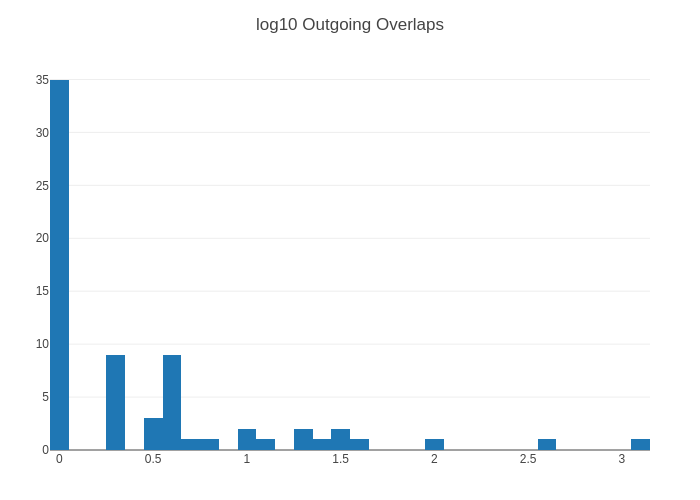

In [19]:
plot(
    histogram(
        x=log10.(species_df[!, :outgoing_overlaps])
    ),
    Layout(
        title="log10 Outgoing Overlaps"
    )
)

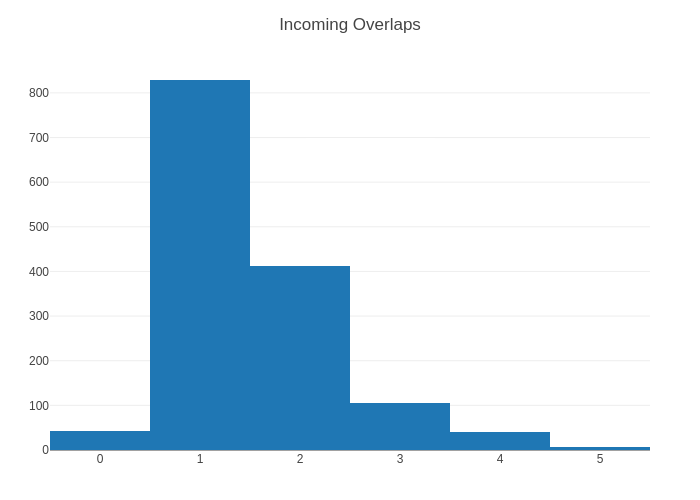

In [20]:
plot(
    histogram(
        x=species_df[!, :incoming_overlaps]
    ),
    Layout(
        title="Incoming Overlaps"
    )
)

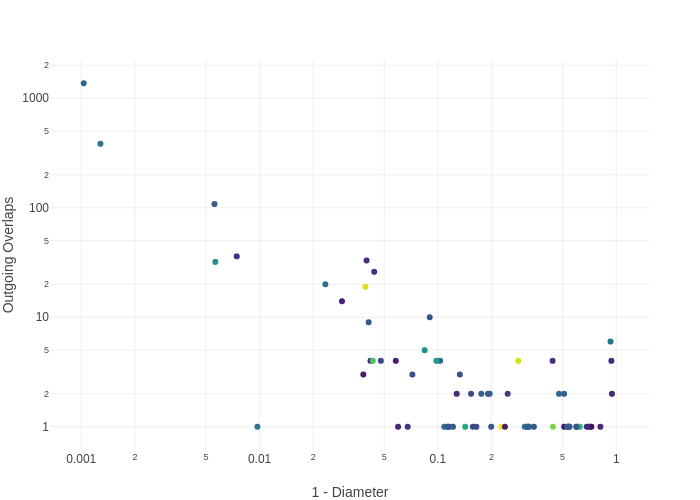

In [21]:
let
    trace = scatter(
        species_df,
        x=1 .- species_df[!, :diameter],
        y=:outgoing_overlaps,
        customdata=[collect(species_df[i, [:diameter, :incoming_overlaps, :ngenomes]]) for i in 1:nspecies],
        text=:name,
        mode=:markers,
        marker=attr(
            color=log10.(species_df[!, :ngenomes]),
            colorscale="Viridis",
        ),
        hovertemplate="""
        <b>%{text}</b> <br>
        Num genomes: %{customdata[2]} <br>
        Diameter: %{customdata[0]} <br>
        Outgoing: %{y} <br>
        Incoming: %{customdata[1]}
        """,
    )
    
    layout = Layout(
        xaxis=attr(
            type=:log,
            title="1 - Diameter",
        ),
        yaxis=attr(
            type=:log,
            title="Outgoing Overlaps",
        ),
        coloraxis=attr(
            
        ),
        hovermode=:closest,
    )
    
    plot(trace, layout)
end

## Save

In [22]:
CSV.write(intermediate_out / "genomes-addendum.csv", genomes_df[:, [:max_intra]])

p"data-intermediate/210323-find-species-overlaps/genomes-addendum.csv"

In [23]:
CSV.write(intermediate_out / "species-addendum.csv", species_df[:, [:diameter, :outgoing_overlaps, :incoming_overlaps]])

p"data-intermediate/210323-find-species-overlaps/species-addendum.csv"

In [24]:
overlaps_df = DataFrame(NamedTuple{(:src, :dst)}.(overlaps))
sort!(overlaps_df, :src)

CSV.write(intermediate_out / "species-overlaps.csv", overlaps_df)

p"data-intermediate/210323-find-species-overlaps/species-overlaps.csv"